## Preparing the data

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing
import tensorflow as tf

from tensorflow.keras import regularizers

In [2]:
''''Get the tabular data from github and the images from google.drive or drive of computer'''

# data from the computer
#path = "C:\\Users\\brian\\Desktop\\minor\\AI project\\model"
# os.chdir(path)
# train_data = pd.read_csv('petfinder-pawpularity-score/train.csv')
# train_data['Pawpularity'] = train_data['Pawpularity']
# display(train_data.head(5))
# csv file as a dataframe

# data from github
url = 'https://raw.githubusercontent.com/Veer56/Pawl_patrol/main/Code/data/train.csv'
train_data = pd.read_csv(url)
train_data.isnull().values.any()
display(train_data.head(5))
display(train_data.describe())

# unzip the images from the zip that is in google drive
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/pawpatrol/petfinder-pawpularity-score.zip

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: train/7e3d6d03218db540c6125630572aa7cd.jpg  
  inflating: train/7e51d9305ec464c1f77cfee35ceb1b4f.jpg  
  inflating: train/7e56aa71d1e091e004703283323e8e7f.jpg  
  inflating: train/7e5d1650d5cda4d68f2ee8ce17c29b25.jpg  
  inflating: train/7e601feb12f2fb03c2d342e54cd47b1e.jpg  
  inflating: train/7e6ca633d2a751af58e1cc220ca519b3.jpg  
  inflating: train/7e717923c22053e51861a24aae701fb0.jpg  
  inflating: train/7e761f47cc1e3038a431f9f196234ab9.jpg  
  inflating: train/7e7921ed945c3c863882340360c9157d.jpg  
  inflating: train/7e8763e28a01c059b7a8d119c5ae0dc0.jpg  
  inflating: train/7e93691bef9bc381590cf004358ee11a.jpg  
  inflating: train/7e947e83394b6d74f1ec4f5b596bed6a.jpg  
  inflating: train/7e9d46bd87849a49ada5f2c336c9d929.jpg  
  inflating: train/7e9df6c36fd06411ce717d0ce761af35.jpg  
  inflating: train/7ea78b0c0bb036b1bbb76b99ec0b731c.jpg  
  inflating: train/7ead412443b3b7f598c53fbf9335caac.jpg  
  inflating: train

In [9]:
def load_images_from_folder(folder, data = [], size=64):

    samples = len(data)    
    images = [None] * samples    
    width = [None] * samples
    height = [None] * samples
    
    for count, filename in enumerate(os.listdir(folder)):
        name = filename.strip('.jpg')
        index = train_data[train_data['Id']==name].index.item()
        
        img_original = cv2.imread(os.path.join(folder,filename))
        width[index] = img_original.shape[0]
        height[index] = img_original.shape[1]
        
        img = cv2.resize(img_original, (size, size))

        if img is not None:
            images[index] = img

        
        if count % 1000 == 0:  
              
          print(f"{round(count / samples *100, 0)}%")

    return np.array(images), np.array(data['Pawpularity']), np.array(data['Id']), width, height

image, image_labels, image_names, width, height = load_images_from_folder('train', data = train_data)

print(f'Training labels loaded: {image.shape}')

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
61.0%
71.0%
81.0%
91.0%
Training labels loaded: (9912, 64, 64, 3)


In [10]:
'''split the data in train and test parts of 80% for train and 20% test with random at 11'''

image_train, image_test, label_train, label_test, name_train, name_test = train_test_split(image, image_labels, image_names, test_size=0.2, random_state=11)



In [11]:
''' Test if the label and name are the same'''

print(label_train.shape)
print(name_train.shape)
print(image_train.shape)


(7929,)
(7929,)
(7929, 64, 64, 3)


## Making the model

In [12]:
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing
import tensorflow as tf

In [13]:

def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    ''' Make the model to train and evaluate the data'''

    model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    train_gen = preprocessing.image.ImageDataGenerator(preprocess, augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

Epoch 1/20
248/248 [==============================] - 26s 56ms/step - loss: 1187.7676 - root_mean_squared_error: 30.8679 - val_loss: 1314.3986 - val_root_mean_squared_error: 35.4572
Epoch 2/20
248/248 [==============================] - 10s 41ms/step - loss: 1053.9882 - root_mean_squared_error: 29.3725 - val_loss: 1070.8604 - val_root_mean_squared_error: 31.9107
Epoch 3/20
248/248 [==============================] - 10s 42ms/step - loss: 1001.8685 - root_mean_squared_error: 29.0635 - val_loss: 674.1678 - val_root_mean_squared_error: 23.2749
Epoch 4/20
248/248 [==============================] - 10s 40ms/step - loss: 966.7645 - root_mean_squared_error: 28.6410 - val_loss: 1272.7303 - val_root_mean_squared_error: 35.1420
Epoch 5/20
248/248 [==============================] - 10s 41ms/step - loss: 920.5686 - root_mean_squared_error: 28.1979 - val_loss: 1091.8392 - val_root_mean_squared_error: 31.7432
Epoch 6/20
248/248 [==============================] - 10s 39ms/step - loss: 888.5231 - root_m

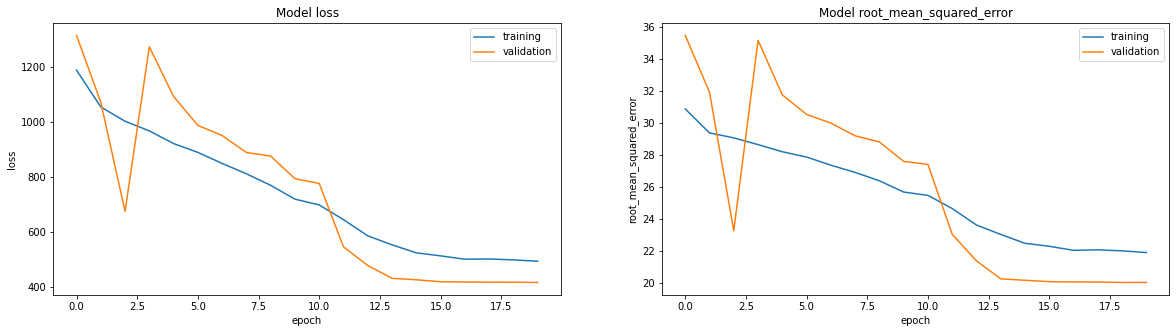

62/62 [==============================] - 1s 12ms/step - loss: 415.2057 - root_mean_squared_error: 20.0469
Validation Accuracy: 20.0468807220459


In [14]:
''' First model with 3 hidden layers, dropout, batchnormalization, activity regularizer,
  featurewise center and featurewise std normalization'''

  
# activity_regularizer=regularizers.l2(1e-3)
# kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),

model=tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
#model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1,activation=None))

preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# train the model and evaluate it with the test_data
train_and_evaluate(model, image_train, label_train, image_test, label_test, preprocess=preprocess, epochs=20)

In [ ]:

predictions = model.predict(image)
print(np.argmin(predictions))
predictions[5367]

5367


array([35.93853], dtype=float32)

# Tabular Data
Four models for training with all the features of the tabular data of the images. Last model is to compare the difference in using the tabular data or not.

In [16]:
train_data['width'] = width
train_data['height'] = height
display(train_data)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,width,height
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,720,405
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,774,1032
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,960,720
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,720,405
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,960,540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15,960,786
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70,960,720
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20,896,696
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20,960,720


In [17]:
''' Divide the data in train and test with the tabular features inculded (X)'''

X = np.array(train_data[['Subject Focus', 'Eyes', 'Face', 'Near', "Action", 'Accessory','Group', 'Collage','Human', 'Occlusion', 'Info', 'Blur', 'width', 'height']])


image_train, image_test, label_train, label_test, X_train, X_test = train_test_split(image, image_labels, X, test_size=0.2, random_state=15)

In [64]:
X.shape
X_train.shape
X_test.sh

(7929, 14)

In [66]:
zeros_train = np.zeros(X_train.shape)
zeros_test = np.zeros(X_test.shape)
ones_train = np.ones(X_train.shape)
ones_test = np.ones(X_test.shape)

In [18]:
''' Second methode of train and evaluate that can handle the combined data of images
   and tabular'''

def train_and_evaluate_2(model, train_x, train_y, val_x, val_y, X_train, X_test, preprocess={}, epochs=20, augment={}):
    ''' Make the model to train and evaluate the data'''

    # compile the model using adam as optimizer with mean squared error as loss function
    model.compile(optimizer='adam',
              loss='MSE',
              metrics=['RootMeanSquaredError'])

    train_gen = preprocessing.image.ImageDataGenerator(preprocess, augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(val_x)

    # estimate the model using the compile 
    history = model.fit(train_gen.flow((train_x, X_train), train_y), epochs=epochs, 
                        validation_data=val_gen.flow((val_x, X_test), val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    # plot the learning curves
    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

Epoch 1/20
248/248 [==============================] - 11s 37ms/step - loss: 1108.6066 - root_mean_squared_error: 28.8593 - val_loss: 746.1245 - val_root_mean_squared_error: 23.6918
Epoch 2/20
248/248 [==============================] - 9s 36ms/step - loss: 813.9100 - root_mean_squared_error: 26.5938 - val_loss: 965.2109 - val_root_mean_squared_error: 25.7385
Epoch 3/20
248/248 [==============================] - 9s 35ms/step - loss: 731.0057 - root_mean_squared_error: 25.8700 - val_loss: 644.5863 - val_root_mean_squared_error: 24.6232
Epoch 4/20
248/248 [==============================] - 9s 36ms/step - loss: 679.9627 - root_mean_squared_error: 25.2167 - val_loss: 642.1611 - val_root_mean_squared_error: 21.8588
Epoch 5/20
248/248 [==============================] - 9s 36ms/step - loss: 663.1276 - root_mean_squared_error: 25.0148 - val_loss: 516.1230 - val_root_mean_squared_error: 22.0488
Epoch 6/20
248/248 [==============================] - 9s 36ms/step - loss: 637.7006 - root_mean_squared

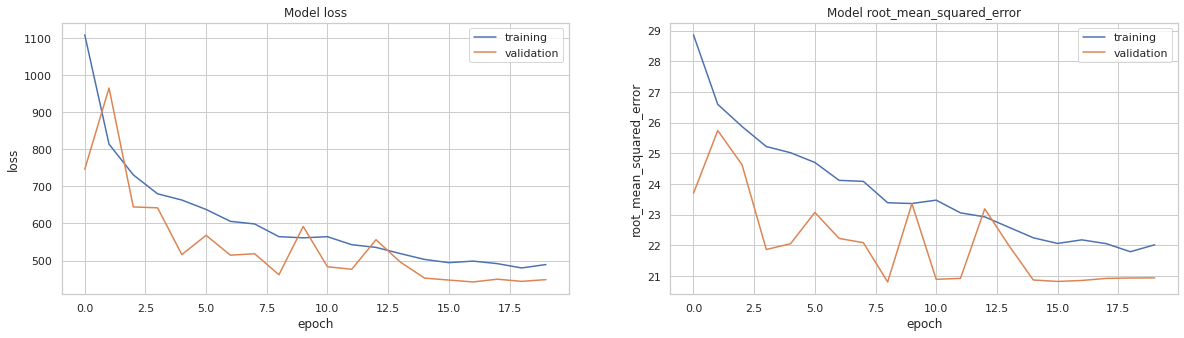

In [78]:
''' Second model where the tabular data has 4 dense layers'''

model_img = tf.keras.Input(shape = image_train.shape[1:])

model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same')(model_img)
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

model_img_3 = tf.keras.layers.Dropout(0.3)(model_img_2)
model_img_4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_3)
model_img_5 = tf.keras.layers.MaxPool2D((2,2))(model_img_4)
model_img_6 = layers.BatchNormalization()(model_img_5)

model_img_7 = tf.keras.layers.Dropout(0.3)(model_img_6)
model_img_8 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_7)
model_img_9 = tf.keras.layers.MaxPool2D((2,2))(model_img_8)
model_img_10 = layers.BatchNormalization()(model_img_9)

model_img_11 = tf.keras.layers.Dropout(0.3)(model_img_10)
model_img_12 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-2))(model_img_11)
model_img_13 = tf.keras.layers.MaxPool2D((2,2))(model_img_12)
model_img_14 = layers.BatchNormalization()(model_img_13)
model_img_15 = tf.keras.layers.Flatten()(model_img_14)

##### tabular
test_2_tabular = tf.keras.Input(shape = X.shape[1:], name = 'tabular') 
test_2_tabular1 = tf.keras.layers.Dense(30, activation='relu', name='tabular1')(test_2_tabular)
test_2_tabular2 = tf.keras.layers.Dense(50, activation='relu', name='tabular2')(test_2_tabular1)
test_2_tabular3 = tf.keras.layers.Dense(30, activation='relu', name='tabular3')(test_2_tabular2)
test_2_tabular4 = tf.keras.layers.Dense(10, activation='relu', name='tabular4')(test_2_tabular3)

##### Concatenate
model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([test_2_tabular4, model_img_15])

model_img_16 = tf.keras.layers.Dense(256, activation='relu')(model_concat)
model_img_17 = tf.keras.layers.Dropout(0.7)(model_img_16)
model_img_18 = tf.keras.layers.Dense(128,activation='relu')(model_img_17)
model_img_19 = tf.keras.layers.Dropout(0.7)(model_img_18)
model_img_20 = tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-2))(model_img_19)
model_img_21 = tf.keras.layers.Dropout(0.6)(model_img_20)


model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_img_21)


model = tf.keras.Model(inputs = [model_img, test_2_tabular], outputs = model_fin)


preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# train the model and evaluate it with the test_data
train_and_evaluate_2(model, image_train, label_train, image_test, label_test, X_train, X_test, preprocess, epochs=20)

In [79]:
predictions = model.predict([image_test, X_test])
print(predictions[np.argmax(predictions)])
print(predictions[np.argmin(predictions)])
print(predictions)

[41.756542]
[35.54701]
[[36.86877 ]
 [36.86687 ]
 [36.569244]
 ...
 [35.852375]
 [37.253696]
 [36.876442]]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


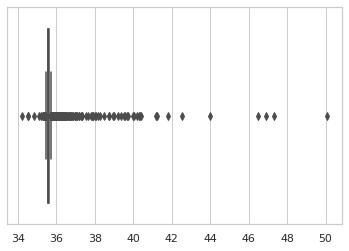

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(predictions)
plt.show()

# testing ones and zeros

zeros

Epoch 1/20
248/248 [==============================] - 11s 37ms/step - loss: 1129.7273 - root_mean_squared_error: 29.0587 - val_loss: 844.8729 - val_root_mean_squared_error: 26.0967
Epoch 2/20
248/248 [==============================] - 9s 36ms/step - loss: 788.6909 - root_mean_squared_error: 26.1110 - val_loss: 604.5289 - val_root_mean_squared_error: 23.5628
Epoch 3/20
248/248 [==============================] - 9s 36ms/step - loss: 712.8339 - root_mean_squared_error: 25.4638 - val_loss: 645.0264 - val_root_mean_squared_error: 24.2580
Epoch 4/20
248/248 [==============================] - 9s 36ms/step - loss: 681.5250 - root_mean_squared_error: 25.1658 - val_loss: 732.0674 - val_root_mean_squared_error: 25.6389
Epoch 5/20
248/248 [==============================] - 9s 35ms/step - loss: 650.5009 - root_mean_squared_error: 24.7695 - val_loss: 543.6387 - val_root_mean_squared_error: 21.6735
Epoch 6/20
248/248 [==============================] - 9s 35ms/step - loss: 623.7340 - root_mean_squared

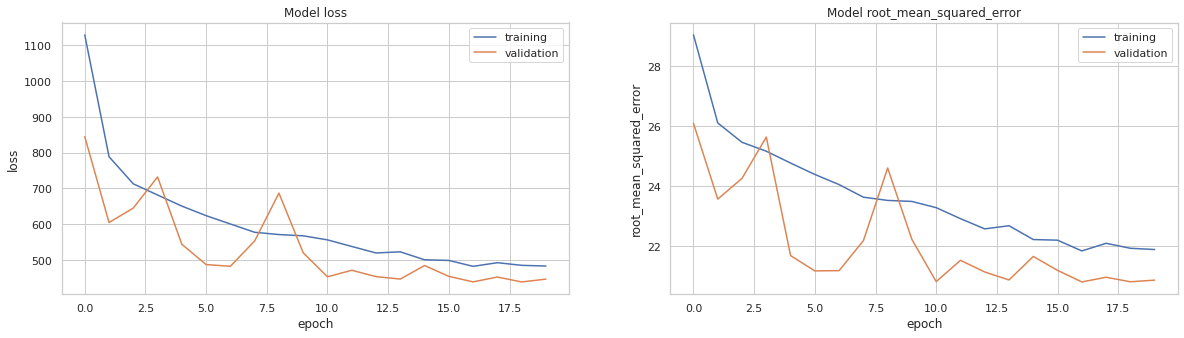

In [81]:
''' Second model where the tabular data has 4 dense layers'''

model_img = tf.keras.Input(shape = image_train.shape[1:])

model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same')(model_img)
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

model_img_3 = tf.keras.layers.Dropout(0.3)(model_img_2)
model_img_4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_3)
model_img_5 = tf.keras.layers.MaxPool2D((2,2))(model_img_4)
model_img_6 = layers.BatchNormalization()(model_img_5)

model_img_7 = tf.keras.layers.Dropout(0.3)(model_img_6)
model_img_8 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_7)
model_img_9 = tf.keras.layers.MaxPool2D((2,2))(model_img_8)
model_img_10 = layers.BatchNormalization()(model_img_9)

model_img_11 = tf.keras.layers.Dropout(0.3)(model_img_10)
model_img_12 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-2))(model_img_11)
model_img_13 = tf.keras.layers.MaxPool2D((2,2))(model_img_12)
model_img_14 = layers.BatchNormalization()(model_img_13)
model_img_15 = tf.keras.layers.Flatten()(model_img_14)

##### tabular
test_2_tabular = tf.keras.Input(shape = X.shape[1:], name = 'tabular') 
test_2_tabular1 = tf.keras.layers.Dense(30, activation='relu', name='tabular1')(test_2_tabular)
test_2_tabular2 = tf.keras.layers.Dense(50, activation='relu', name='tabular2')(test_2_tabular1)
test_2_tabular3 = tf.keras.layers.Dense(30, activation='relu', name='tabular3')(test_2_tabular2)
test_2_tabular4 = tf.keras.layers.Dense(10, activation='relu', name='tabular4')(test_2_tabular3)

##### Concatenate
model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([test_2_tabular4, model_img_15])

model_img_16 = tf.keras.layers.Dense(256, activation='relu')(model_concat)
model_img_17 = tf.keras.layers.Dropout(0.7)(model_img_16)
model_img_18 = tf.keras.layers.Dense(128,activation='relu')(model_img_17)
model_img_19 = tf.keras.layers.Dropout(0.7)(model_img_18)
model_img_20 = tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-2))(model_img_19)
model_img_21 = tf.keras.layers.Dropout(0.6)(model_img_20)


model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_img_21)


model = tf.keras.Model(inputs = [model_img, test_2_tabular], outputs = model_fin)


preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# train the model and evaluate it with the test_data
train_and_evaluate_2(model, image_train, label_train, image_test, label_test, zeros_train, zeros_test, preprocess, epochs=20)

In [82]:
predictions = model.predict([image_test, zeros_test])
print(predictions[np.argmax(predictions)])
print(predictions[np.argmin(predictions)])
print(predictions)

[53.648266]
[34.28097]
[[35.46757 ]
 [35.46757 ]
 [35.46757 ]
 ...
 [35.272427]
 [35.46757 ]
 [35.46757 ]]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


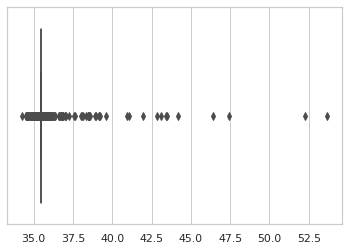

In [83]:
sns.boxplot(predictions)
plt.show()

Ones

Epoch 1/20
248/248 [==============================] - 10s 35ms/step - loss: 863.1662 - root_mean_squared_error: 28.2615 - val_loss: 1124.3741 - val_root_mean_squared_error: 33.1141
Epoch 2/20
248/248 [==============================] - 8s 34ms/step - loss: 755.4472 - root_mean_squared_error: 26.2201 - val_loss: 1098.8092 - val_root_mean_squared_error: 32.4264
Epoch 3/20
248/248 [==============================] - 8s 34ms/step - loss: 739.4522 - root_mean_squared_error: 25.8314 - val_loss: 750.0397 - val_root_mean_squared_error: 25.9324
Epoch 4/20
248/248 [==============================] - 8s 34ms/step - loss: 729.2152 - root_mean_squared_error: 25.5996 - val_loss: 1120.2095 - val_root_mean_squared_error: 32.3020
Epoch 5/20
248/248 [==============================] - 8s 34ms/step - loss: 700.5658 - root_mean_squared_error: 25.2020 - val_loss: 1173.9958 - val_root_mean_squared_error: 33.1732
Epoch 6/20
248/248 [==============================] - 9s 37ms/step - loss: 696.2404 - root_mean_squa

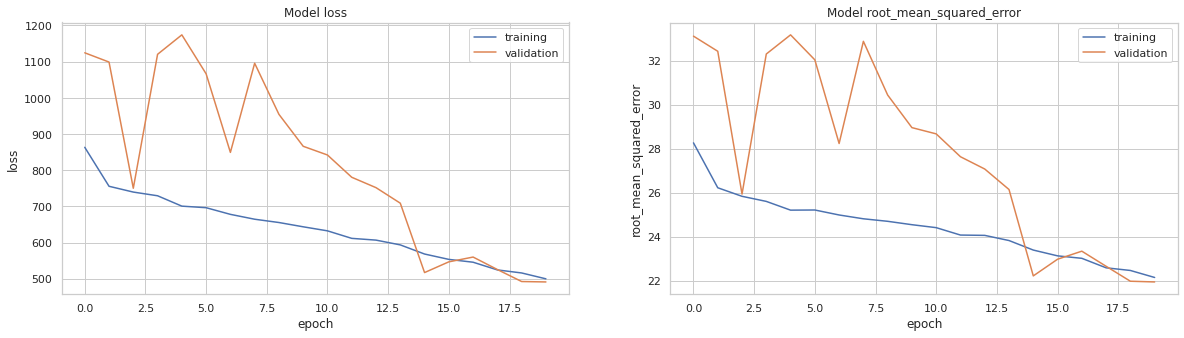

In [84]:
''' Second model where the tabular data has 4 dense layers'''

model_img = tf.keras.Input(shape = image_train.shape[1:])

model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same')(model_img)
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

model_img_3 = tf.keras.layers.Dropout(0.3)(model_img_2)
model_img_4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_3)
model_img_5 = tf.keras.layers.MaxPool2D((2,2))(model_img_4)
model_img_6 = layers.BatchNormalization()(model_img_5)

model_img_7 = tf.keras.layers.Dropout(0.3)(model_img_6)
model_img_8 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_7)
model_img_9 = tf.keras.layers.MaxPool2D((2,2))(model_img_8)
model_img_10 = layers.BatchNormalization()(model_img_9)

model_img_11 = tf.keras.layers.Dropout(0.3)(model_img_10)
model_img_12 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4))(model_img_11)
model_img_13 = tf.keras.layers.MaxPool2D((2,2))(model_img_12)
model_img_14 = layers.BatchNormalization()(model_img_13)
model_img_15 = tf.keras.layers.Flatten()(model_img_14)

##### tabular
test_2_tabular = tf.keras.Input(shape = X.shape[1:], name = 'tabular') 

##### Concatenate
model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([test_2_tabular, model_img_15])

model_img_16 = tf.keras.layers.Dense(256, activation='relu')(model_concat)
model_img_17 = tf.keras.layers.Dropout(0.7)(model_img_16)
model_img_18 = tf.keras.layers.Dense(128,activation='relu')(model_img_17)
model_img_19 = tf.keras.layers.Dropout(0.7)(model_img_18)
model_img_20 = tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-2))(model_img_19)
model_img_21 = tf.keras.layers.Dropout(0.5)(model_img_20)


model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_img_21)


model = tf.keras.Model(inputs = [model_img, test_2_tabular], outputs = model_fin)


preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# train the model and evaluate it with the test_data
train_and_evaluate_2(model, image_train, label_train, image_test, label_test, ones_train, ones_test, preprocess, epochs=20)

In [85]:
predictions = model.predict([image_test, ones_test])
print(predictions[np.argmax(predictions)])
print(predictions[np.argmin(predictions)])
print(predictions)


[37.452232]
[26.301006]
[[28.766842]
 [31.072552]
 [30.854055]
 ...
 [26.805021]
 [32.49683 ]
 [29.621523]]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


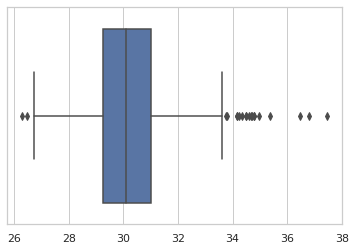

In [86]:
sns.boxplot(predictions)
plt.show()